**Gautier Daures & Pierre Romon**

# Time Series

The problem addresses the prediction of a future trend from a time series. Here, we have the monthly retail debit card usage in Iceland (million ISK) from january 2000 to december 2012 and we want to predict the cumulated debit card usage during the 4 first months of 2013. Frequencies and nature of the concerned time seris alongside the choice and the validation of the model will be carefully pondered.

## Libraries importations

* numpy: using mathematical tools on matrix
* pandas: data analysis and manipulation tool
* matplotlib.pyplot: ploting graphs to represent data
* product form itertools to perform the cartesian product of 2 lists
* boxcox from scipy.stats: performing Box-Cox transformation
* adfuller from statsmodels.tsa.stattools: performing Augmented Dickey-Fuller statistical test
* plot_acf and plot_pacf from statsmodels.graphics.tsaplots: plotting ACF and PACF
* seasonal_decompose from statsmodels.tsa.seasona: decomposing a time-serie
* sarimax from statsmodels.tsa.statespace.sarimax: performing a sarimax transformation of the time-serie

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import product
from scipy.stats import boxcox
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX as sarimax

## Time serie overview

First thing to do is to import the time series which is stored in a CSV file. Time series can be interpreted as particular dataframes whose index is eventually the date of the sample. Here, we observe that the index are the first of each month for each sample, so we set the index frequence accordingly. The unique variable is a float named V1. We store the index in a variable, so that it can be reused in the following steps.

In [2]:
ts = pd.read_csv('data/debitcards.csv', index_col=0, parse_dates=True)
ts.index.freq = 'MS'
index = ts.index
ts.head()

,V1
2000-01-01,7204.0
2000-02-01,7335.0
2000-03-01,7812.0
2000-04-01,7413.0
2000-05-01,9136.0


By plotting the serie, it is obvious that it is not stationnary and following an increasing trend through years.

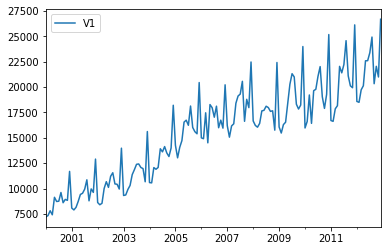

In [3]:
ts.plot()
plt.show()

Now that we have observed graphically non-stationarity, we would like to assert it with a statistical test. Thus, we decide to use the Augmented Dickey-Fuller statistical test that permits the rejection of the stationnary hypothesis if the computed p-value is low (under  0.05). As we are likely to perform this test several times, we decide to implement a short function to simplify its usage.

In [4]:
def adf_test(ts):
    test = adfuller(ts)
    p_value = test[1]
    return p_value

The p-value of the test is much greater than 0.05, therefore it indicates that the stationnary hypothesis can be rejected with strong confidence.

In [5]:
adf_test(ts)

0.7881064417185542

In the time serie field of study, the AutoCorrelation Function (ACF) is playing a major part and is linked to the Moving Average (MA) model. In addition, it can be interesting to study also the Partial AutoCorrelation Function (PACF) which permit to distinct AutoRegulated (AR) model and its combination with MA (ARMA). As we may be brought to plot several times these 2 functions, we decide to implement a function for this task.

In [6]:
def plot_acf_pacf(ts):
    fig, ax = plt.subplots(2, figsize=(8,4))
    plot_acf(ts, zero=False, ax=ax[0])
    plot_pacf(ts, zero=False, ax=ax[1])
    plt.show()

Through this charts, we observe that the ACF is linear which does not help us to find the order of moving average. Tranforming the time serie in a stationnary one may be necessary to get an exploitable ACF plot.

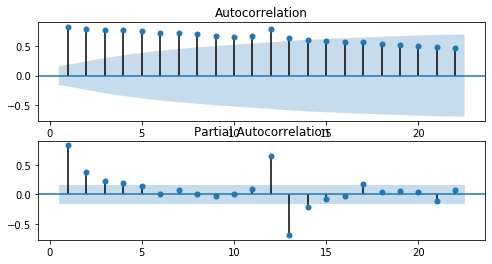

In [7]:
plot_acf_pacf(ts)

It may be interesting to find how many differencing are necessary to transform this time serie in a stationnary time serie. Therefore, we difference the time serie before performing again a Augmented Dickey-Fuller statistical test. The resulting p-value is between 0.01 and 0.05, meaning that the single-differenciated time serie is very likely to be a stationnary. The plot below confirms this tendency.

In [8]:
ts_diff = ts.diff()
ts_diff.dropna(inplace=True)
adf_test(ts_diff)

0.03815703587781361

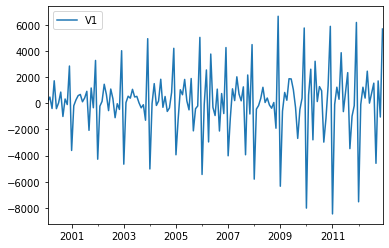

In [9]:
ts_diff.plot()
plt.show()

Now that we have a stationnary time serie, let's plot again the ACF and PACF. First of all, we notice that the ACF is no more linear and so we can estimate the order of moving average process which is 4. From the PACF, we can deduce that the order of autoregressive process is 6. This observation, completed by the need of 1 differencing leads us to conclude that an ARIMAX(6,1,4) may be an appropriate model.

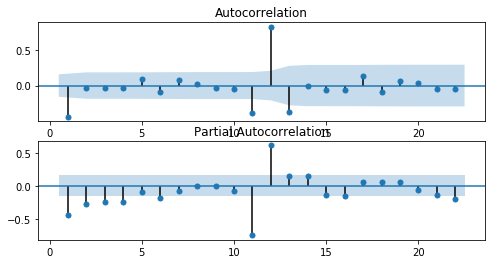

In [10]:
plot_acf_pacf(ts_diff)

We can go further in the graphical study of the time serie by decomposing it. Thus, it is possible to analyze its components one by one which makes their study easier. Here, the time serie is decomposed in its trend, its season and its residuals. The following plots confirm our initial deductions about the increasing trend. We also oberve a yearly pattern in the season plot which means that the time serie behave in the same manner each year. Finally, the residuals seem to be stationnary.

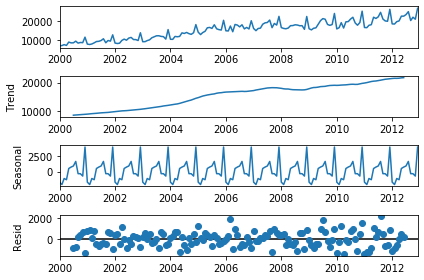

In [11]:
decomposition = seasonal_decompose(ts)
decomposition.plot()
plt.show()

We want to confirm the stationnary hypothesis of the residuals. Let's perform an Augmented Dickey-Fuller test on it. The result of the test allows us to accept the stationnary hypothesis. Thus, the residuals can be interpreted as a white noise.

In [12]:
resid = decomposition.resid
resid.dropna(inplace=True)
adf_test(decomposition.resid)

0.0001963564453499327

## Model selection

We already have some clues about the model to use and the parameters to tune, namely SARIMAX(6,1,4). It is now time to confirm these conjectures with rigor and method. We try several parameters combinaisons for p and q, in a range based on our suppositions. Then, we select the best SARIMAX model, based on its efficiency. We choose to select the one that minimizes the AIC (Akaike Information Criterion) criteria. Thus, according to this optimization process, an ARIMAX(6,1,7) seems to be the best model and it will be used in the next steps. It is interesting to note here that it is close to the model that we found graphically at first glance.

In [13]:
def optimize_sarimax(low, up, data):
    ps = range(low, up, 1)
    d = 1
    qs = range(low, up, 1)
    parameters = product(ps, qs)
    parameters_list = list(parameters)
    
    order_list = []
    for each in parameters_list:
        each = list(each)
        each.insert(1, 1)
        each = tuple(each)
        order_list.append(each)
    
    results = []
    for order in order_list:
        try: 
            model = sarimax(data, order=order, enforce_invertibility=False, enforce_stationarity=False)
            model = model.fit(maxiter=1000, disp=False)
        except:
            continue
            
        results.append([order, model.aic, model.bic, model.mse])
        
    result_df = pd.DataFrame(results, columns=['(p, d, q)', 'AIC', 'BIC', 'MSE'])
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    return result_df

result_df = optimize_sarimax(0, 8, ts)
result_df.head()

,"(p, d, q)",AIC,BIC,MSE
0,"(6, 1, 7)",2623.016785,2664.882841,3.119886e+06
1,"(7, 1, 5)",2625.368358,2664.332118,3.017077e+06
2,"(6, 1, 6)",2634.820012,2673.783772,2.779638e+06
3,"(7, 1, 6)",2635.284061,2677.245033,2.774181e+06
4,"(3, 1, 7)",2639.974729,2672.869487,3.501270e+06


For the next steps, we want to divide our time serie in a training one and a testing one. The division is made on a date that leave approximately a training bigger than the testing set.

In [14]:
ts_train = ts[:"2006-01-01"] 
ts_test = ts["2006-01-01":]

Now that we choose our model and split our dataset in a training and a testing partitions, it is time to train the selected model. Right after training, we decide to consult the built-in diagnostic of the training to ensure that the model is appropriate. By looking the histogram of residuals and the normal Q-Q plot, it is easy to conclude that the residuals are normally distributed. Moreover,the correlogram shows that they are not correlated.

[]

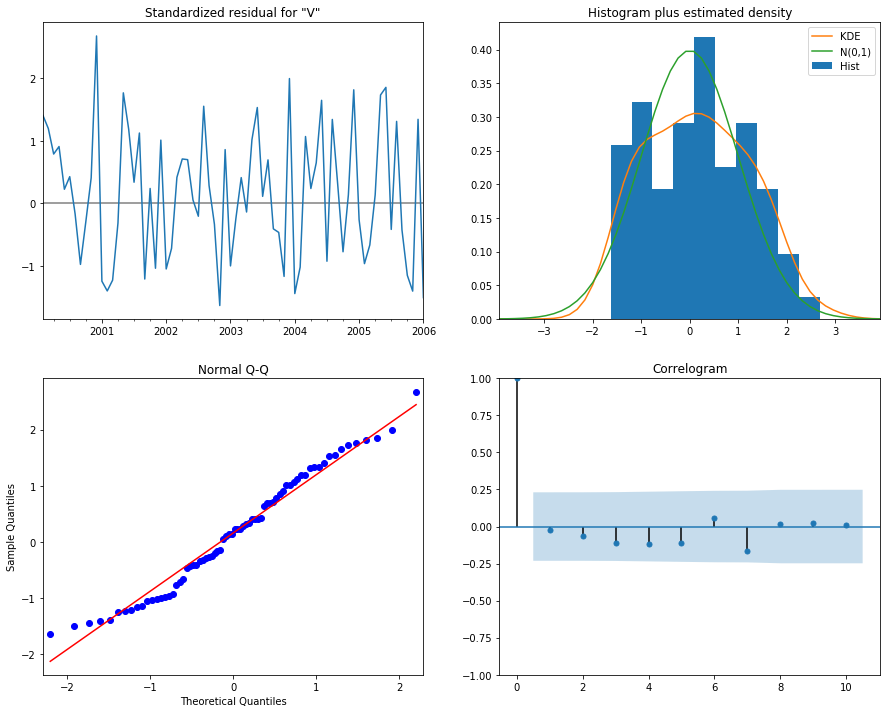

In [15]:
model = sarimax(ts_train, order=(6,1,7), enforce_invertibility=False)
model_fit = model.fit(maxiter=2000)
model_fit.plot_diagnostics(figsize=(15, 12))
plt.plot()

## Prediction

Our model is ready to be tested on the test dataset. Here, we compare the predictions from our trained model and the data of the original time serie. The best way to compare the predictions with the actual data in the scope of a time serie is to plot both of them on the same plot and compare the predicted points to the time serie curve. As expected, the predictions match well the true data. 

[]

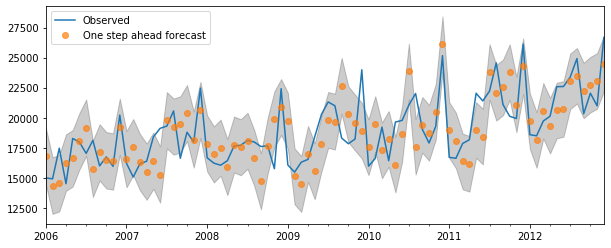

In [16]:
model_test = sarimax(ts, order=(6,1,7))
model_test_res = model_test.filter(model_fit.params)
pred = model_test_res.get_prediction(start='2006-01-01')
pred_ci = pred.conf_int()
ax = ts_test.plot(y='V1', label='Observed', figsize=(10,4))
pred.predicted_mean.plot(ax=ax, label="One step ahead forecast", alpha=0.7, linestyle='', marker='o')
ax.fill_between(pred_ci.index, pred_ci['lower V1'], pred_ci['upper V1'], color='k', alpha=0.2)
plt.legend()
plt.plot()

We are satisfied with our model and its training. Last step is now to predict future events thanks to this model. Here we want to predict the cumulated debit card usage during the 4 first months of 2013. The resulting time serie is hard to interpret without context, that is with the previous events represented by the original time serie.

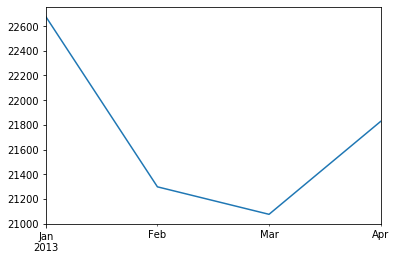

In [17]:
forecast = model_test_res.get_forecast(steps=4)
forecast.predicted_mean.plot()
plt.show()

Thus, we decided to plot our predictions following the previous data from the original time serie. The result is much more interpretable and match approximately with the previous patterns that occur at the beginning of each year. Indeed, the values are much lower on the first months compared to the high values at the end of the past year.

[]

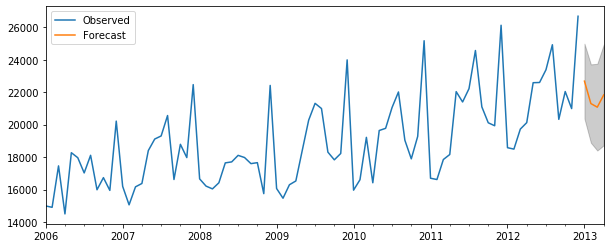

In [18]:
forecast_ci = forecast.conf_int()
ax = ts_test.plot(y='V1', label='Observed', figsize=(10,4))
forecast.predicted_mean.plot(ax=ax, label="Forecast", alpha=1)
ax.fill_between(forecast_ci.index, forecast_ci['lower V1'], forecast_ci['upper V1'], color='k', alpha=0.2)
plt.legend()
plt.plot()

Answering the question is now easy since we only need to sum the predictions to find the cumulated debit card usage of the first 4 month of 2013. The following cell give the this cumulated result.

In [19]:
sum(forecast.predicted_mean)

86876.86167607974

## Conclusion

The analysis of our time serie has shown non-stationnary caracteristics. With a difference, we made it stationnary and we asserted that the noise was a white noise. After these preliminaries, we estimated graphically the best parameters p and q for our model. To confirm our hypothesis, we performed a test on several parameters combinations and found the best p and q. We applied a sarimax with these parameters, and the estimations are actually close to true values. The forecast for the three first months of 2013 seems to be well estimated and not aberrant.